# Cálculo de Energia Livre em Catálise usando VASP e ASE

Autor: [Arthur Hardiagon](https://github.com/ahardiag) 

Contato: [ahardiagon@eq.ufrj.br](mailto:ahardiagon@eq.ufrj.br) - [Programa de Engenharia Química, PEQ/COPPE, UFRJ, Brasil](https://www.peq.coppe.ufrj.br/)

---

**Chemical reaction**

$ COOH (ads)+ OH (ads) \to CO_2 (ads) + H_2O (ads)$ 

We want to access the difference of free energy of this reaction on the surface of Platinum 111n ("ads" state).

We assume low concentrations of gas, so that we can use ideal gas theory to compute thermodynamic properties.

Only the thermodynamic properties are computed, the mechanism and the kinetics of the reaction are not treated in this notebook.

In [1]:
import os
# Definindo o path para os arquivos de potencial de pseudopotenciais do VASP
# Certifique-se de que o caminho esteja correto para o seu sistema
os.environ['VASP_PP_PATH'] = '/home/public/Programs/vasp.6.5.1/pp'
os.environ['ASE_VASP_COMMAND'] = 'mpirun -np 1 vasp_std'
os.environ['NO_STOP_MESSAGE'] = '1' # to avoid warning from mpirun

# Importando o VASP calculator do ASE
from ase.calculators.vasp import Vasp

from ase import Atoms
from ase.io import write, read
from ase.visualize import view

import numpy as np

## Relaxation of free molecules 

### Building COOH compound from formic acid

The structure of a close molecule, the acid formic, has been downloaded SDF format in the [Pubchem](https://pubchem.ncbi.nlm.nih.gov/compound/Formic-Acid) database:

In [2]:
o2ch2 = read("inputs/Conformer3D_COMPOUND_CID_284.sdf")

In [3]:
view(o2ch2,viewer='x3d')

In [4]:
cooh = o2ch2.copy()
cooh.get_atomic_numbers(),cooh.get_positions()

(array([8, 8, 6, 1, 1]),
 array([[-1.1685e+00,  1.8250e-01,  0.0000e+00],
        [ 1.1146e+00,  2.1030e-01,  0.0000e+00],
        [ 5.3800e-02, -3.9270e-01,  0.0000e+00],
        [-5.1100e-02, -1.4875e+00,  2.0000e-04],
        [-1.1142e+00,  1.1620e+00,  0.0000e+00]]))

In [5]:
cooh.pop(3)
cooh.get_number_of_atoms()

/tmp/ipykernel_1337876/1006092051.py:2: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.
  cooh.get_number_of_atoms()


4

In [6]:
view(cooh,viewer='x3d')

In [7]:
cooh.get_center_of_mass()

array([-0.02975027,  0.06084331,  0.        ])

In [8]:
cooh.center(vacuum=6.0)
cooh.pbc = True
cooh.get_center_of_mass()

array([7.13874973, 6.45354331, 6.        ])

### Relaxation of COOH

In [9]:
%%time
calc_relax = Vasp(
    directory='cooh_relax',
    xc='PBE',
    encut=450,
    ismear=0, sigma=0.05,  # smearing : smooth the heavidide function in evalutation of expectation, for numerical stability
    ediff=1e-6, ediffg=-0.01, # related to stop criteria for gradient descent algorithm
    isif=2, ibrion=2, nsw=100, # calculate stress and forces, update only positions
    nelm=100, # max numebr of SCF steps
    lwave=True, lcharg=True, lvtot=True, # output options
    atoms=cooh
)
calc_relax.calculate(cooh) # demora por 3 minutos

E_cooh = cooh.get_potential_energy()

print(f'Optimized energy of COOH: {E_cooh:.3f} eV')

Optimized energy of COOH: -23.932 eV
CPU times: user 68 ms, sys: 27.3 ms, total: 95.3 ms
Wall time: 1min 19s


In [10]:
%%time
# 5 min
calc_vib = Vasp(
    directory='cooh_vib',
    xc='PBE',
    encut=450,
    ismear=0, sigma=0.05,
    ediff=1e-8,
    ibrion=6,           # finite differences with symmetry
    lreal=False,
    lwave=False, lcharg=False,
    atoms=cooh
)

calc_vib.calculate(cooh)

vib_cooh = calc_vib.get_vibrations()

# Frequencies (cm⁻¹)
freqs = vib_cooh.get_frequencies()

print(f'Vibrational frequencies of COOH (cm⁻¹):')
vib_energies_cooh = []
for freq in freqs:
    if freq.real > 200:
        vib_energy = (freq.real * 1.23981e-4)  # Convert cm⁻¹ to eV
        vib_energies_cooh.append(vib_energy)
        print(f'f_v: {freq.real:.3f} cm⁻¹, E_v: {vib_energy:.3f} eV')

Vibrational frequencies of COOH (cm⁻¹):
f_v: 554.116 cm⁻¹, E_v: 0.069 eV
f_v: 563.956 cm⁻¹, E_v: 0.070 eV
f_v: 1002.438 cm⁻¹, E_v: 0.124 eV
f_v: 1243.773 cm⁻¹, E_v: 0.154 eV
f_v: 1797.961 cm⁻¹, E_v: 0.223 eV
f_v: 3360.826 cm⁻¹, E_v: 0.417 eV
CPU times: user 114 ms, sys: 38.1 ms, total: 153 ms
Wall time: 3min 6s


### Relaxation of OH 

In [11]:
%%time
oh = Atoms('HO',
            positions=[[0.768, 0.000, 0.595], # from water geometry
                       [0.000, 0.000, 0.000]]) # geometria otimizada com PBE
oh.center(vacuum=6.0)  
oh.pbc = True

calc_relax = Vasp(
    directory='oh_relax',
    xc='PBE',
    encut=450,
    ismear=0, sigma=0.05, # smearing : smooth the heavidide function in evalutation of expectation, for numerical stability
    ediff=1e-6, ediffg=-0.01, # related to stop criteria for gradient descent algorithm
    isif=2, ibrion=2, nsw=100, 
    nelm=100, # max number of SCF steps
    lwave=True, lcharg=True, lvtot=True, 
    atoms=oh
)
calc_relax.calculate(oh) # demora por volta de 10 s

E_oh = oh.get_potential_energy()

print(f'Optimized energy of HO: {E_oh:.3f} eV')

Optimized energy of HO: -7.095 eV
CPU times: user 48.1 ms, sys: 15.9 ms, total: 63.9 ms
Wall time: 20.7 s


In [12]:
%%time
calc_vib = Vasp(
    directory='oh_vib',
    xc='PBE',
    encut=450,
    ismear=0, sigma=0.05,
    ediff=1e-8,
    ibrion=6,           # finite differences with symmetry
    lreal=False,
    lwave=False, lcharg=False,
    atoms=oh
)

calc_vib.calculate(oh)

vib_oh = calc_vib.get_vibrations()

# Frequencies (cm⁻¹)
freqs = vib_oh.get_frequencies()

print(f'Vibrational frequencies of OH (cm⁻¹):')
vib_energies_oh = []
for freq in freqs:
    if freq.real > 200:
        vib_energy = (freq.real * 1.23981e-4)  # Convert cm⁻¹ to eV
        vib_energies_oh.append(vib_energy)
        print(f'f_v: {freq.real:.3f} cm⁻¹, E_v: {vib_energy:.3f} eV')

Vibrational frequencies of OH (cm⁻¹):
f_v: 3616.048 cm⁻¹, E_v: 0.448 eV
CPU times: user 91.3 ms, sys: 22.6 ms, total: 114 ms
Wall time: 1min 13s


### Relaxation of water molecule

In [13]:
%%time
h2o = Atoms('H2O',
            positions=[[-0.768, 0.000, 0.595],
                       [0.768, 0.000, 0.595],
                       [0.000, 0.000, 0.000]]) # geometria otimizada com PBE
h2o.center(vacuum=6.0)  
h2o.pbc = True

calc_relax = Vasp(
    directory='h2o_relax',
    xc='PBE',
    encut=450,
    ismear=0, sigma=0.05,
    ediff=1e-6, ediffg=-0.01,
    isif=2, ibrion=2, nsw=100,
    nelm=100,
    lwave=True, lcharg=True, lvtot=True,
    atoms=h2o
)
calc_relax.calculate(h2o) # demora por volta de 10 s

E_h2o = h2o.get_potential_energy()

print(f'Optimized energy of H2O: {E_h2o:.3f} eV')

Optimized energy of H2O: -14.219 eV
CPU times: user 31.8 ms, sys: 15 ms, total: 46.8 ms
Wall time: 15.6 s


Calculo dos modos vibracionais

In [14]:
%%time
calc_vib = Vasp(
    directory='h2o_vib',
    xc='PBE',
    encut=450,
    ismear=0, sigma=0.05,
    ediff=1e-8,
    ibrion=6,           # finite differences with symmetry
    lreal=False,
    lwave=False, lcharg=False,
    atoms=h2o
)

calc_vib.calculate(h2o)

vib_water = calc_vib.get_vibrations()

# Frequencies (cm⁻¹)
freqs = vib_water.get_frequencies()

print(f'Vibrational frequencies of H2O (cm⁻¹):')
vib_energies_h2o = []
for freq in freqs:
    if freq.real > 200:
        vib_energy = (freq.real * 1.23981e-4)  # Convert cm⁻¹ to eV
        vib_energies_h2o.append(vib_energy)
        print(f'f_v: {freq.real:.3f} cm⁻¹, E_v: {vib_energy:.3f} eV')

Vibrational frequencies of H2O (cm⁻¹):
f_v: 1584.762 cm⁻¹, E_v: 0.196 eV
f_v: 3728.000 cm⁻¹, E_v: 0.462 eV
f_v: 3840.056 cm⁻¹, E_v: 0.476 eV
CPU times: user 79.2 ms, sys: 30.1 ms, total: 109 ms
Wall time: 1min 14s


### Relaxation of CO2


In [15]:
%%time
co2 = Atoms('CO2',
            positions=[[0.000, 0.000, 0.000],
                       [0.000, 0.000, 1.177],
                       [0.000, 0.000, -1.177]]) # geometria otimizada com PBE
co2.center(vacuum=6.0)  
co2.pbc = True

calc_relax = Vasp(
    directory='co2_relax',
    xc='PBE',
    encut=450,
    ismear=0, sigma=0.05,
    ediff=1e-6, ediffg=-0.01,
    isif=2, ibrion=2, nsw=100,
    nelm=100,
    lwave=True, lcharg=True, lvtot=True,
    atoms=co2
)
calc_relax.calculate(co2) # demora por volta de .. ?? s

E_co2 = co2.get_potential_energy()

print(f'Optimized energy of CO2: {E_co2:.3f} eV')

Optimized energy of CO2: -22.960 eV
CPU times: user 116 ms, sys: 31.6 ms, total: 147 ms
Wall time: 15.1 s


In [16]:
%%time
calc_vib = Vasp(
    directory='co2_vib',
    xc='PBE',
    encut=450,
    ismear=0, sigma=0.05,
    ediff=1e-8,
    ibrion=6,           # finite differences with symmetry
    lreal=False,
    lwave=False, lcharg=False,
    atoms=co2
)

calc_vib.calculate(co2)

vib_co2 = calc_vib.get_vibrations()

# Frequencies (cm⁻¹)
freqs = vib_co2.get_frequencies()

print(f'Vibrational frequencies of CO2 (cm⁻¹):')
vib_energies_co2 = []
for freq in freqs:
    if freq.real > 200:
        vib_energy = (freq.real * 1.23981e-4)  # Convert cm⁻¹ to eV
        vib_energies_co2.append(vib_energy)
        print(f'f_v: {freq.real:.3f} cm⁻¹, E_v: {vib_energy:.3f} eV')

Vibrational frequencies of CO2 (cm⁻¹):
f_v: 631.428 cm⁻¹, E_v: 0.078 eV
f_v: 631.428 cm⁻¹, E_v: 0.078 eV
f_v: 1317.718 cm⁻¹, E_v: 0.163 eV
f_v: 2366.073 cm⁻¹, E_v: 0.293 eV
CPU times: user 56.3 ms, sys: 23.3 ms, total: 79.6 ms
Wall time: 1min 2s


### Relaxation of the Pt surface

In [17]:
from ase.lattice.cubic import FaceCenteredCubic
from ase.build import fcc111

In [18]:
%%time
# bulk system
Pt_crystal = FaceCenteredCubic(size=(1, 1, 1), symbol='Pt', latticeconstant=3.967, pbc=True)

calc_relax = Vasp(directory='Pt_relax',
                xc='PBE',
                kpts=[6, 6, 6],  # specifies k-points
                encut=450,
                ismear=0, sigma=0.05,
                ediff=1e-6, ediffg=-0.01,
                isif=7, ibrion=2, nsw=100, # ionic relaxation (ISIF=7: relax cell volume only)
                atoms=Pt_crystal
                )
calc_relax.calculate(Pt_crystal) # demora por volta de 2 s

E_Pt = Pt_crystal.get_potential_energy()

a0_Pt = Pt_crystal.cell.cellpar()[0]

print(f'Optimized energy of Pt: {E_Pt:.3f} eV')
print(f"Lattice length: {a0_Pt:.3f} Å")

Optimized energy of Pt: -24.458 eV
Lattice length: 3.967 Å
CPU times: user 56.4 ms, sys: 11.3 ms, total: 67.7 ms
Wall time: 3.9 s


In [19]:
%%time

# Superfície Pt111
Pt111_slab = fcc111("Pt", size=(2,2,3), a=a0_Pt)
Pt111_slab.center(vacuum=5.0, axis=2) # adicionar vacuo pela direção z
Pt111_slab.pbc = True

calc_relax = Vasp(directory='Pt111_slab_relax',
                xc='PBE',
                kpts=[6, 6, 1],  # specifies k-points
                encut=450,
                ismear=0, sigma=0.05,
                ediff=1e-6, ediffg=-0.01,
                ibrion=-1, # just SCF (no ionic relaxation)
                atoms=Pt111_slab
                )
calc_relax.calculate(Pt111_slab) # demora por volta de 12 s

E_Pt111 = Pt111_slab.get_potential_energy()

print(f'Optimized energy of Pt111: {E_Pt111:.3f} eV')

Optimized energy of Pt111: -67.924 eV
CPU times: user 53.9 ms, sys: 11.7 ms, total: 65.6 ms
Wall time: 11.9 s


## Thermodynamic properties in ideal gas

In [20]:
from ase.thermochemistry import IdealGasThermo

# Reagents
cooh_thermo = IdealGasThermo(vib_energies=vib_energies_cooh,
                        potentialenergy=E_cooh, atoms=cooh,
                        geometry='nonlinear', # no axial symetry around the principal axis
                        symmetrynumber=1,     # only one planar symmetry
                        spin = 0.5)           # a free radical due to the loss of CH bond
                                                                        

oh_thermo = IdealGasThermo(vib_energies=vib_energies_oh,
                        potentialenergy=E_oh, atoms=oh,
                        geometry='linear', # like CO2
                        symmetrynumber=1,  # like CO2
                        spin=0.5)          # a free radical due to the loss of one hydrogen atom

# Products
h2o_thermo = IdealGasThermo(vib_energies=vib_energies_h2o,
                        potentialenergy=E_h2o, atoms=h2o,
                        geometry='nonlinear', symmetrynumber=2, spin=0)

co2_thermo = IdealGasThermo(vib_energies=vib_energies_co2,
                        potentialenergy=E_co2, atoms=co2,
                        geometry='linear', symmetrynumber=2, spin=0)


P = 101325. # Pa
T = 298.15 # K

G_cooh = cooh_thermo.get_gibbs_energy(temperature=T, pressure=P, verbose=False)
H_cooh = cooh_thermo.get_enthalpy(temperature=T, verbose=False)

G_oh = oh_thermo.get_gibbs_energy(temperature=T, pressure=P, verbose=False)
H_oh = oh_thermo.get_enthalpy(temperature=T, verbose=False)

G_h2o = h2o_thermo.get_gibbs_energy(temperature=T, pressure=P, verbose=False)
H_h2o = h2o_thermo.get_enthalpy(temperature=T, verbose=False)

G_co2 = co2_thermo.get_gibbs_energy(temperature=T, pressure=P, verbose=False)
H_co2 = co2_thermo.get_enthalpy(temperature=T, verbose=False)

# Enthalpy and Free energy variations during reaction; it is likely a theoretical result
# this reaction does not occur in the gas phase (unless maybe under powerful radiation to obtain radicals)
# COOH + HO -> CO2 + OH

Gwgs = G_co2 + G_h2o - (G_cooh + G_oh)
Hwgs = H_co2 + H_h2o - (H_cooh + H_oh)

print('Reaction: COOH + OH -> CO2 + H2O')
print(f'at T={T} K and P={P} Pa:')
print(f'ΔG = {Gwgs:.3f} eV = {Gwgs*96.485:.3f} kJ/mol')
print(f'ΔH = {Hwgs:.3f} eV = {Hwgs*96.485:.3f} kJ/mol')


Reaction: COOH + OH -> CO2 + H2O
at T=298.15 K and P=101325.0 Pa:
ΔG = -5.949 eV = -573.960 kJ/mol
ΔH = -6.034 eV = -582.199 kJ/mol


## Adsorption of chemical species

In [21]:
from ase.constraints import FixAtoms
from ase.build import add_adsorbate

### Adsorption of COOH on the top Pt111 

$ COOH + * \to COOH*$ 

This [article](https://iopscience.iop.org/article/10.1088/1742-6596/1494/1/012040) suggest a stable position for COOH compound adsorbed in Pt111 : the fragment is aligned with platinum atoms with the carbon atom at a distance $d=2.04$Å of the Pt atoms (in top position), and the hydrogen atom pointing towards the Pt surface.

In [22]:
cooh = Atoms('OCH',
            positions=[[-1.1685e+00,  1.8250e-01,  0.0000e+00], # from formic acid, see above
                        #[ 1.1146e+00,  2.1030e-01,  0.0000e+00],
                        [ 5.3800e-02, -3.9270e-01,  0.0000e+00],
                        #[-5.1100e-02, -1.4875e+00,  2.0000e-04]]#,
                        [-1.1142e+00,  1.1620e+00,  0.0000e+00]]
            )

# --- indices ---
iO,iC,iH = 0,1,3

# --- rotation axis (C–O bond) ---
axis = cooh[iO].position - cooh[iC].position
axis /= np.linalg.norm(axis)

# --- rotation center = carbon atom ---
center = cooh[iC].position

# --- rotate only the hydrogen atom by 180° ---
cooh.rotate(a=180, v=axis, center=center, rotate_cell=False)

# Add the missing oxygen atom from the original structure of formic acid
cooh.extend(Atoms('O',positions=[[ 1.1146e+00,  2.1030e-01,  0.0000e+00]]))

# Add a rotation 

# visualize
view(cooh, viewer='x3d')

In [23]:
cooh.get_atomic_numbers()

array([8, 6, 1, 8])

In [24]:
COOHads_slab = fcc111("Pt", size=(2,2,3), a=a0_Pt)
COOHads_slab.center(vacuum=5.0, axis=2)
COOHads_slab.pbc = True

cooh.rotate('x',90)       # Rotate the molecule around its main axis (x) to 90°
                          # so that the hydrogen points towards the Pt atom
add_adsorbate(COOHads_slab,  adsorbate=cooh, height=2.04, position = (4.20, 2.42), mol_index=1)

In [25]:
view(COOHads_slab,viewer='x3d')

In [26]:
%%time
# DFT relaxation of the whole system Pt + COOH
# fixando os átomos de Pt
constraint = FixAtoms(mask=[atom.symbol=='Pt' for atom in COOHads_slab])
COOHads_slab.set_constraint([constraint])

calc_relax = Vasp(directory='Pt111_COOH_relax',
                xc='PBE',
                kpts=[6, 6, 1],  # specifies k-points
                encut=450,
                ismear=0, sigma=0.05,
                ediff=1e-6, ediffg=-0.01,
                isif=0, ibrion=2, nsw=100, # ionic relaxation (ISIF=2: relax atoms position only)
                atoms=COOHads_slab
                )
calc_relax.calculate(COOHads_slab) # demora por volta de ??? min

E_Pt111_COOH= COOHads_slab.get_potential_energy()

print(f'Optimized energy of OH in top position of Pt111: {E_Pt111_COOH:.3f} eV')


Optimized energy of OH in top position of Pt111: -94.696 eV
CPU times: user 718 ms, sys: 302 ms, total: 1.02 s
Wall time: 2h 12min 45s


In [27]:
%%time

calc_vib = Vasp(
    directory='Pt111_COOH_vib',
    xc='PBE',
    kpts=[6, 6, 1],
    encut=450,
    ismear=0, sigma=0.05,
    ediff=1e-8,
    ibrion=5,nfree=2, nsw=1,
    lreal=False,lwave=False, lcharg=False,
    atoms=COOHads_slab
)

calc_vib.calculate(COOHads_slab)

vib_Pt111_cooh = calc_vib.get_vibrations()

# Frequencies (cm⁻¹)
freqs = vib_Pt111_cooh.get_frequencies()

print(f'Vibrational frequencies of COOH on Pt111 (cm⁻¹):')

vib_energie_Pt111_cooh = []
for freq in freqs:
    if freq.real > 200:
        vib_energy = (freq.real * 1.23981e-4)  # Convert cm⁻¹ to eV
        vib_energie_Pt111_cooh.append(vib_energy)
        print(f'f_v: {freq.real:.3f} cm⁻¹, E_v: {vib_energy:.3f} eV')

Vibrational frequencies of COOH on Pt111 (cm⁻¹):
f_v: 270.431 cm⁻¹, E_v: 0.034 eV
f_v: 289.263 cm⁻¹, E_v: 0.036 eV
f_v: 511.133 cm⁻¹, E_v: 0.063 eV
f_v: 618.995 cm⁻¹, E_v: 0.077 eV
f_v: 659.449 cm⁻¹, E_v: 0.082 eV
f_v: 1111.769 cm⁻¹, E_v: 0.138 eV
f_v: 1197.658 cm⁻¹, E_v: 0.148 eV
f_v: 1639.178 cm⁻¹, E_v: 0.203 eV
f_v: 3425.082 cm⁻¹, E_v: 0.425 eV
CPU times: user 455 ms, sys: 128 ms, total: 583 ms
Wall time: 1h 20min 48s


In [28]:
cooh_Pt111_thermo = IdealGasThermo(vib_energies=vib_energie_Pt111_cooh,
                        potentialenergy=E_Pt111_COOH, atoms=COOHads_slab,
                        geometry='nonlinear', symmetrynumber=2, spin=0)

G_cooh_Pt111 = cooh_Pt111_thermo.get_gibbs_energy(temperature=T, pressure=P, verbose=False)
H_cooh_Pt111 = cooh_Pt111_thermo.get_enthalpy(temperature=T, verbose=False)

In [29]:
Hads_cooh = H_cooh_Pt111 - H_cooh - E_Pt111
      
print(f'ΔH (OH) adsorption = {Hads_cooh:.3f} eV')

ΔH (OH) adsorption = -2.739 eV


### Adsorption of OH on the surface of Pt111

$OH + *\to OH*$

A quick [search](https://sites.psu.edu/dftap/2019/03/29/exploring-process-energetic-and-tilt-angles-of-adsorption-of-oh-on-pt111/) (no peer reviewed, careful) suggest that the oxygen atoms stands on top of the Pt atom at a distance $d\approx	1.975 $ Å and the tilt angle between OH bond and the normal axis of the surface would be $\theta \approx 73.5°$.

In [30]:
OHads_slab = fcc111("Pt", size=(2,2,3), a=a0_Pt)
OHads_slab.center(vacuum=5.0, axis=2)
OHads_slab.pbc = True

In [31]:
# Initialize the system with OH in the normal axis of the surface
oh = Atoms('HO',
            positions=[[0.768, 0.595, 0.000],
                       [0.000, 0.000, 0.000]]) # from water geometry (PBE relaxation)

oh.rotate('z', 104.46/2) # put the OH bond in the plane 111
oh.rotate('x', 90)       # rotaciona a molécula em 90 graus em torno do eixo z
oh.rotate('y', 73.5)     # rotate the bond in agreement with the angle from another study
oh.rotate('z', 30)       # The study suggests the OH bond is towards hollow of the 111 surface

add_adsorbate(OHads_slab,  adsorbate=oh, height=1.975, position = (4.20, 2.42), mol_index=1)

In [32]:
view(OHads_slab,viewer='x3d')

In [33]:
%%time

# fixando os átomos de Pt
constraint = FixAtoms(mask=[atom.symbol=='Pt' for atom in OHads_slab])
OHads_slab.set_constraint([constraint])

calc_relax = Vasp(directory='Pt111_OH_relax',
                xc='PBE',
                kpts=[6, 6, 1],  # specifies k-points
                encut=450,
                ismear=0, sigma=0.05,
                ediff=1e-6, ediffg=-0.01,
                isif=0, ibrion=2, nsw=100, # ionic relaxation (ISIF=2: relax atoms position only)
                atoms=OHads_slab
                )
calc_relax.calculate(OHads_slab) # demora por volta de ??? min

E_Pt111_OH= OHads_slab.get_potential_energy()

print(f'Optimized energy of OH in top position of Pt111: {E_Pt111_OH:.3f} eV')


Optimized energy of OH in top position of Pt111: -77.906 eV
CPU times: user 251 ms, sys: 85 ms, total: 336 ms
Wall time: 38min 6s


In [34]:
%%time

calc_vib = Vasp(
    directory='Pt111_OH_vib',
    xc='PBE',
    kpts=[6, 6, 1],
    encut=450,
    ismear=0, sigma=0.05,
    ediff=1e-8,
    ibrion=5,nfree=2, nsw=1,
    lreal=False,lwave=False, lcharg=False,
    atoms=OHads_slab
)

calc_vib.calculate(OHads_slab)

vib_Pt111_oh = calc_vib.get_vibrations()

# Frequencies (cm⁻¹)
freqs = vib_Pt111_oh.get_frequencies()

print(f'Vibrational frequencies of OH on Pt111 (cm⁻¹):')

vib_energie_Pt111_oh = []
for freq in freqs:
    if freq.real > 200:
        vib_energy = (freq.real * 1.23981e-4)  # Convert cm⁻¹ to eV
        vib_energie_Pt111_oh.append(vib_energy)
        print(f'f_v: {freq.real:.3f} cm⁻¹, E_v: {vib_energy:.3f} eV')

Vibrational frequencies of OH on Pt111 (cm⁻¹):
f_v: 508.490 cm⁻¹, E_v: 0.063 eV
f_v: 917.726 cm⁻¹, E_v: 0.114 eV
f_v: 3642.160 cm⁻¹, E_v: 0.452 eV
CPU times: user 265 ms, sys: 83.3 ms, total: 348 ms
Wall time: 40min 53s


In [35]:
oh_Pt111_thermo = IdealGasThermo(vib_energies=vib_energie_Pt111_oh,
                        potentialenergy=E_Pt111_OH, atoms=OHads_slab,
                        geometry='nonlinear', symmetrynumber=2, spin=0)

G_oh_Pt111 = oh_Pt111_thermo.get_gibbs_energy(temperature=T, pressure=P, verbose=False)
H_oh_Pt111 = oh_Pt111_thermo.get_enthalpy(temperature=T, verbose=False)

In [36]:
Hads_oh = H_oh_Pt111 - H_oh - E_Pt111
      
print(f'ΔH (OH) adsorption = {Hads_oh:.3f} eV')

ΔH (OH) adsorption = -2.777 eV


### Water Adsorption

$ H_2 O + * \to H_2 O*$ 

Optimize geometry of $H_2 O$ molecule adsorbed on top of Pt111. To this later, we used a previous calculation to spare time in DFT relaxation.

In [40]:
# Read a previous VASP output and take the final configuration
H2Oads_slab = read("inputs/XDATCAR_Pt111_H20_relax")

In [41]:
view(H2Oads_slab,viewer='x3d')

In [42]:
# fixando os átomos de Pt
constraint = FixAtoms(mask=[atom.symbol=='Pt' for atom in H2Oads_slab])
H2Oads_slab.set_constraint([constraint])

calc_relax = Vasp(directory='Pt111_H2O_relax',
                xc='PBE',
                kpts=[6, 6, 1],  # specifies k-points
                encut=450,
                ismear=0, sigma=0.05,
                ediff=1e-6, ediffg=-0.01,
                isif=0, ibrion=2, nsw=100, # ionic relaxation (ISIF=2: relax atoms position only)
                atoms=H2Oads_slab
                )
calc_relax.calculate(H2Oads_slab) # demora por volta de 260 min

E_Pt111_H2O= H2Oads_slab.get_potential_energy()

print(f'Optimized energy of H2O in top position of Pt111: {E_Pt111_H2O:.3f} eV')


Optimized energy of H2O in top position of Pt111: -82.354 eV


In [43]:
E_ads_Pt111_H2O = E_Pt111_H2O - E_Pt111 - E_h2o

print(f'Adsorption energy of H2O on Pt111: {E_ads_Pt111_H2O:.3f} eV')

Adsorption energy of H2O on Pt111: -0.211 eV


In [44]:
calc_vib = Vasp(
    directory='Pt111_H2O_vib',
    xc='PBE',
    kpts=[6, 6, 1],
    encut=450,
    ismear=0, sigma=0.05,
    ediff=1e-8,
    ibrion=5,nfree=2, nsw=1,           # finite differences with selective dynamics (Pt atoms fixed)
    lreal=False,lwave=False, lcharg=False,
    atoms=H2Oads_slab
)

calc_vib.calculate(H2Oads_slab)

vib_Pt111_h2o = calc_vib.get_vibrations()

# Frequencies (cm⁻¹)
freqs = vib_Pt111_h2o.get_frequencies()

print(f'Vibrational frequencies of H2O on Pt111 (cm⁻¹):')

vib_energie_Pt111_h2o = []
for freq in freqs:
    if freq.real > 200:
        vib_energy = (freq.real * 1.23981e-4)  # Convert cm⁻¹ to eV
        vib_energie_Pt111_h2o.append(vib_energy)
        print(f'f_v: {freq.real:.3f} cm⁻¹, E_v: {vib_energy:.3f} eV')

Vibrational frequencies of H2O on Pt111 (cm⁻¹):
f_v: 482.869 cm⁻¹, E_v: 0.060 eV
f_v: 539.687 cm⁻¹, E_v: 0.067 eV
f_v: 1551.532 cm⁻¹, E_v: 0.192 eV
f_v: 3579.972 cm⁻¹, E_v: 0.444 eV
f_v: 3680.169 cm⁻¹, E_v: 0.456 eV


In [45]:
h2o_Pt111_thermo = IdealGasThermo(vib_energies=vib_energie_Pt111_h2o,
                        potentialenergy=E_Pt111_H2O, atoms=H2Oads_slab,
                        geometry='nonlinear', symmetrynumber=2, spin=0)

G_h2o_Pt111 = h2o_Pt111_thermo.get_gibbs_energy(temperature=T, pressure=P, verbose=False)
H_h2o_Pt111 = h2o_Pt111_thermo.get_enthalpy(temperature=T, verbose=False)

In [46]:
Hads_h2o = H_h2o_Pt111 - H_h2o - E_Pt111
      
print(f'ΔH h2o adsorption = {Hads_h2o:.3f} eV')

ΔH h2o adsorption = -0.157 eV


### Adsorption of CO2 on Pt 111
$ CO2 + * \to CO2*$ 

In [47]:
# Adsorvendo a molécula de CO2 na superfície Pt111

CO2ads_slab = fcc111("Pt", size=(2,2,3), a=a0_Pt)
CO2ads_slab.center(vacuum=5.0, axis=2)
CO2ads_slab.pbc = True

co2 = Atoms('CO2',
            positions=[[0.000, 0.000, 0.000],
                       [1.177, 0.000, 0.000],
                       [-1.177, 0.000, 0.000]]) # geometria otimizada com PBE

add_adsorbate(CO2ads_slab,  adsorbate=co2, height=2.5, position ='ontop', mol_index=0 )

# fixando os átomos de Pt
constraint = FixAtoms(mask=[atom.symbol=='Pt' for atom in CO2ads_slab])
CO2ads_slab.set_constraint([constraint])

calc_relax = Vasp(directory='Pt111_CO2_relax',
                xc='PBE',
                kpts=[6, 6, 1],  # specifies k-points
                encut=450,
                ismear=0, sigma=0.05,
                ediff=1e-6, ediffg=-0.01,
                isif=0, ibrion=2, nsw=100, # ionic relaxation (ISIF=2: relax atoms position only)
                atoms=CO2ads_slab
                )
calc_relax.calculate(CO2ads_slab) # demora por volta de 29 min

E_Pt111_CO2= CO2ads_slab.get_potential_energy()

print(f'Optimized energy of CO2 in top position of Pt111: {E_Pt111_CO2:.3f} eV')


Optimized energy of CO2 in top position of Pt111: -90.896 eV


In [48]:
E_ads_Pt111_CO2 = E_Pt111_CO2 - E_Pt111 - E_co2

print(f'Adsorption energy of CO2 on Pt111: {E_ads_Pt111_CO2:.3f} eV')

Adsorption energy of CO2 on Pt111: -0.012 eV


In [49]:
calc_vib = Vasp(
    directory='Pt111_CO2_vib',
    xc='PBE',
    kpts=[6, 6, 1],
    encut=450,
    ismear=0, sigma=0.05,
    ediff=1e-8,
    ibrion=5,nfree=2, nsw=1,           # finite differences with selective dynamics (Pt atoms fixed)
    lreal=False,lwave=False, lcharg=False,
    atoms=CO2ads_slab
)

calc_vib.calculate(CO2ads_slab)

vib_Pt111_co2 = calc_vib.get_vibrations()

# Frequencies (cm⁻¹)
freqs = vib_Pt111_co2.get_frequencies()

print(f'Vibrational frequencies of CO2 on Pt111 (cm⁻¹):')

vib_energie_Pt111_co2 = []
for freq in freqs:
    if freq.real > 200:
        vib_energy = (freq.real * 1.23981e-4)  # Convert cm⁻¹ to eV
        vib_energie_Pt111_co2.append(vib_energy)
        print(f'f_v: {freq.real:.3f} cm⁻¹, E_v: {vib_energy:.3f} eV')

Vibrational frequencies of CO2 on Pt111 (cm⁻¹):
f_v: 627.042 cm⁻¹, E_v: 0.078 eV
f_v: 628.687 cm⁻¹, E_v: 0.078 eV
f_v: 1318.436 cm⁻¹, E_v: 0.163 eV
f_v: 2348.760 cm⁻¹, E_v: 0.291 eV


In [50]:
co2_Pt111_thermo = IdealGasThermo(vib_energies=vib_energie_Pt111_co2,
                        potentialenergy=E_Pt111_CO2, atoms=CO2ads_slab,
                        geometry='nonlinear', symmetrynumber=2, spin=0)

G_co2_Pt111 = co2_Pt111_thermo.get_gibbs_energy(temperature=T, pressure=P, verbose=False)
H_co2_Pt111 = co2_Pt111_thermo.get_enthalpy(temperature=T, verbose=False)

In [51]:
Hads_co2 = H_co2_Pt111 - H_co2 - E_Pt111
      
print(f'ΔH CO2 adsorption = {Hads_co2:.3f} eV')

ΔH CO2 adsorption = -0.000 eV


## Resultado Final


| Reação                                 | $\Delta E$ (eV)  | $\Delta H$ (eV) |
|----------------------------------------|----------|------------|
| $ COOH + ^* \rightleftarrows COOH^*$   |          |      |
| $ OH + * \rightleftarrows OH*$         |          |      |
| $ CO2 + * \rightleftarrows CO2*$       |          |      |
| $ H_2 O + * \rightleftarrows H_2 0*$   |          |      |


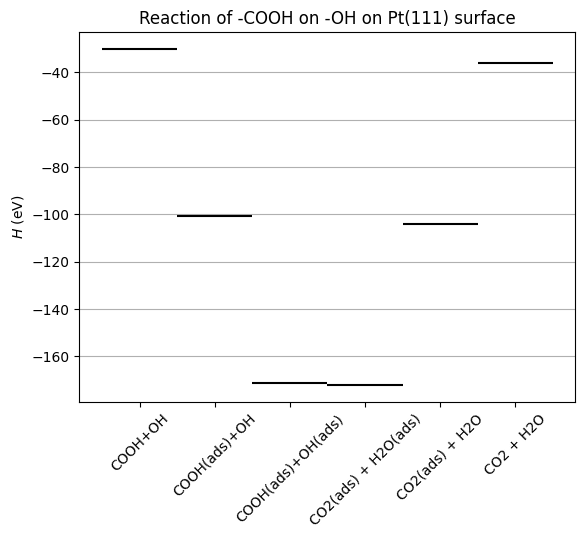

In [53]:
from matplotlib import pyplot as plt

plt.hlines(H_cooh+H_oh            , xmin=0, xmax=1, colors='black')
plt.hlines(H_cooh_Pt111+H_oh      , xmin=1, xmax=2, colors='black')
plt.hlines(H_cooh_Pt111+H_oh_Pt111, xmin=2, xmax=3, colors='black')
plt.hlines(H_co2_Pt111+H_h2o_Pt111, xmin=3, xmax=4, colors='black')
plt.hlines(H_co2_Pt111+H_h2o      , xmin=4, xmax=5, colors='black')
plt.hlines(H_co2+H_h2o            , xmin=5, xmax=6, colors='black')

plt.ylabel(r'$H$ (eV)')
plt.xticks([0.5,1.5, 2.5, 3.5, 4.5, 5.5], ['COOH+OH','COOH(ads)+OH','COOH(ads)+OH(ads)','CO2(ads) + H2O(ads)', 'CO2(ads) + H2O', 'CO2 + H2O'], rotation=45)
plt.title('Reaction of -COOH on -OH on Pt(111) surface')
plt.grid(axis='y')